In [1]:
## FASE 1: SETUP DAN PEMUATAN DATA

# Import library dasar
import pandas as pd
import numpy as np
import re
import time

# Import untuk Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from ast import literal_eval # Untuk mengubah string '[...]' menjadi list

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import umap

print("Semua library berhasil diimpor.")

# --- Memuat Dataset ---
# Ganti 'nama_file_anda.csv' dengan nama file CSV Anda yang sebenarnya.
try:
    df = pd.read_csv('hasil_scraping_berita_bangsaonlinecopy.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh data awal:")
    print(df.head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()

Semua library berhasil diimpor.

Dataset berhasil dimuat. Jumlah data: 3653 baris.
Contoh data awal:
   id_berita kategori                                              judul  \
0     153410    Jatim  Diduga Kasus Korupsi, Kejari Geledah Kantor Pe...   
1     153408    Jatim  Pria asal Surabaya Meninggal Mendadak di Pasar...   
2     153407    Jatim  Polres Tuban Kembalikan BB Motor hingga Handph...   
3     153406    Jatim  TMMD ke-126 Sidoarjo Bangun Rumah Warga Guna W...   
4     153405    Jatim  Dana Transfer Dipangkas Pusat, Bupati Gresik S...   

                                          isi_berita  \
0  SURABAYA, BANGSAONLINE.com- Kejari Tanjung Per...   
1  KOTA PASURUAN,BANGSAONLINE.com- Suasana Pasar ...   
2  TUBAN, BANGSAONLINE.com- Satreskrim Polres Tub...   
3  SIDOARJO,BANGSAONLINE.com- Program TNI Manungg...   
4  GRESIK,BANGSAONLINE.com- Bupati Gresik, Fandi ...   

                                                link  
0  https://bangsaonline.com/berita/153410/diduga-.

In [4]:
print("\n--- Memulai Penggabungan Kategori ---")
mapping_kategori = {
    'Jatim': 'Berita Regional Jatim', 'Jatim Barat': 'Berita Regional Jatim',
    'Jatim Madura': 'Berita Regional Jatim', 'Jatim Metro': 'Berita Regional Jatim',
    'Jatim Selatan': 'Berita Regional Jatim', 'Jatim Tengah': 'Berita Regional Jatim',
    'Jatim Timur': 'Berita Regional Jatim', 'Jatim Utara': 'Berita Regional Jatim'
}
df['kategori'] = df['kategori'].replace(mapping_kategori)
print(f"Jumlah kategori setelah digabungkan: {df['kategori'].nunique()}")


# --- FASE 2: Pra-pemrosesan Teks ---
print("\nMemulai Pra-pemrosesan Teks...")


factory = StemmerFactory()
stemmer = factory.create_stemmer()
list_stopwords = stopwords.words('indonesian')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[-+]?[0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in list_stopwords]
    return cleaned_tokens

# Ganti 'isi_berita' dengan nama kolom berita Anda
df['tokens'] = df['isi_berita'].apply(preprocess_text)

# --- CHECKPOINT 1: SIMPAN HASIL PREPROCESSING ---
df.to_csv('berita_cleaned.csv', index=False)
print("\n✅ Pra-pemrosesan selesai. Hasil disimpan ke 'berita_cleaned.csv'")


--- Memulai Penggabungan Kategori ---
Jumlah kategori setelah digabungkan: 30

Memulai Pra-pemrosesan Teks...

✅ Pra-pemrosesan selesai. Hasil disimpan ke 'berita_cleaned.csv'


Data bersih dimuat dari 'berita_cleaned.csv': 3653 baris.

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 2 hingga 40 topik... ---
Selesai menghitung untuk 2 topik...
Selesai menghitung untuk 7 topik...
Selesai menghitung untuk 12 topik...
Selesai menghitung untuk 17 topik...
Selesai menghitung untuk 22 topik...
Selesai menghitung untuk 27 topik...
Selesai menghitung untuk 32 topik...
Selesai menghitung untuk 37 topik...

Total waktu pencarian koherensi: 4.40 menit


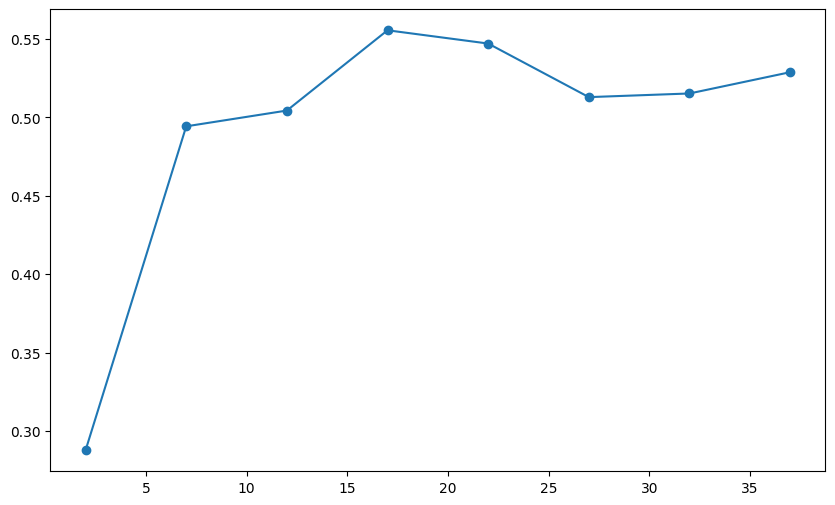


✅ Jumlah topik optimal yang ditemukan: 17

--- Melatih model LDA final dengan 17 topik... ---

✅ Ekstraksi fitur selesai. Hasil disimpan ke 'berita_features.csv'


In [5]:
## BAGIAN 2: EKSTRAKSI FITUR LDA (DARI TEKS BERSIH KE FITUR NUMERIK)

import pandas as pd
import numpy as np
import time
import os
from ast import literal_eval
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel
import matplotlib.pyplot as plt

# --- Cek apakah file hasil sudah ada ---
if os.path.exists('berita_features.csv'):
    print("✅ File 'berita_features.csv' sudah ada. Anda bisa langsung ke BAGIAN 3.")
else:
    # --- Muat data yang sudah bersih dari Checkpoint 1 ---
    df_cleaned = pd.read_csv('berita_cleaned.csv')
    # Konversi kolom 'tokens' dari format string kembali menjadi list
    df_cleaned['tokens'] = df_cleaned['tokens'].apply(literal_eval)
    print(f"Data bersih dimuat dari 'berita_cleaned.csv': {len(df_cleaned)} baris.")

    # --- FASE 3: Ekstraksi Fitur LDA ---
    documents = df_cleaned['tokens'].tolist()
    dictionary = Dictionary(documents)
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    # --- A. Estimasi Jumlah Topik dengan HDP ---
    print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
    hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
    estimated_num_topics = len(hdp_model.print_topics())
    print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")

    # --- B. Mencari Jumlah Topik Terbaik dengan Plot Koherensi ---
    def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
        coherence_values = []
        start_time = time.time()
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                 random_state=42, passes=10, workers=3) # Ganti workers=3 sesuai CPU Anda
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            print(f"Selesai menghitung untuk {num_topics} topik...")
        total_time = time.time() - start_time
        print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
        return coherence_values

    search_start = max(2, estimated_num_topics - 20)
    search_limit = estimated_num_topics + 20
    search_step = 5
    
    print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
    coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                        start=search_start, limit=search_limit, step=search_step)
    x = range(search_start, search_limit, search_step)
    plt.figure(figsize=(10, 6))
    plt.plot(x, coherence_values, marker='o')
    plt.show()
    
    optimal_num_topics = x[np.argmax(coherence_values)]
    print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")

    # --- C. Latih Model LDA Final & Ekstrak Fitur ---
    print(f"\n--- Melatih model LDA final dengan {optimal_num_topics} topik... ---")
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                             random_state=42, passes=15, workers=3)

    def get_lda_features(lda_model, bow_corpus):
        features = np.zeros((len(bow_corpus), optimal_num_topics))
        for i, doc_bow in enumerate(bow_corpus):
            topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
            for topic_id, prob in topic_distribution:
                features[i, topic_id] = prob
        return features

    X = get_lda_features(lda_model, corpus)
    y = df_cleaned['kategori'].values

    # --- CHECKPOINT 2: SIMPAN FITUR DAN LABEL ---
    feature_cols = [f'topic_{i}' for i in range(optimal_num_topics)]
    df_features = pd.DataFrame(X, columns=feature_cols)
    df_features['kategori'] = y
    df_features.to_csv('berita_features.csv', index=False)
    print("\n✅ Ekstraksi fitur selesai. Hasil disimpan ke 'berita_features.csv'")

Data fitur dimuat dari 'berita_features.csv': 3653 baris.

Memulai pelatihan model SVM...

--- HASIL EVALUASI ---
Akurasi Model: 44.05%
                          precision    recall  f1-score   support

   Berita Regional Jatim       0.40      0.89      0.55       160
               Birokrasi       0.00      0.00      0.00        20
                   Dunia       1.00      0.05      0.10        20
                 Ekonomi       0.79      0.95      0.86        20
            Entrepreneur       0.26      0.25      0.26        20
                   Figur       0.00      0.00      0.00        20
        Hukum - Kriminal       0.00      0.00      0.00        20
               Kesehatan       0.52      0.55      0.54        20
Komunitas dan Lingkungan       0.00      0.00      0.00        20
                 Kuliner       0.87      0.65      0.74        20
               Lifestyle       0.45      0.25      0.32        20
                Nasional       0.00      0.00      0.00        20
     

c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Rizky\AppData\Local\Temp\ipykernel_24096\3230157645.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))


NameError: name 'Line2D' is not defined

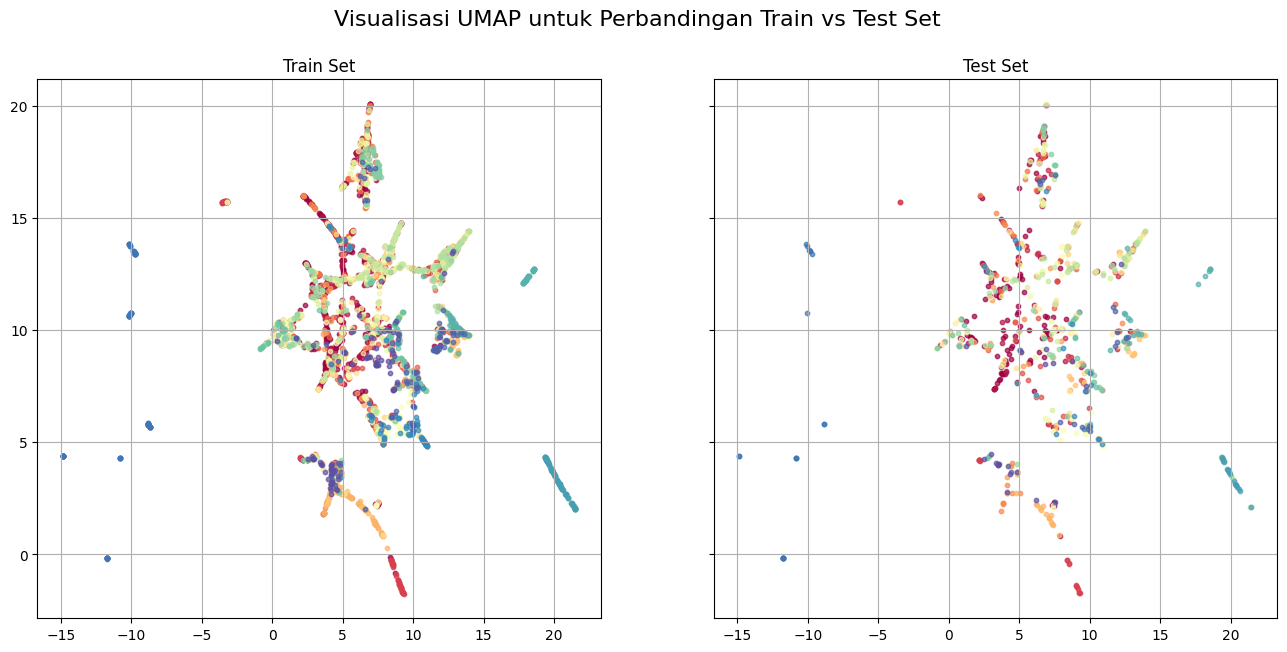

In [ ]:
## BAGIAN 3: PELATIHAN, EVALUASI, DAN VISUALISASI

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

# --- Muat data fitur dari Checkpoint 2 ---
try:
    df_features = pd.read_csv('berita_features.csv')
    print(f"Data fitur dimuat dari 'berita_features.csv': {len(df_features)} baris.")
except FileNotFoundError:
    print("❌ Error: File 'berita_features.csv' tidak ditemukan. Jalankan BAGIAN 2 terlebih dahulu.")

if 'df_features' in locals():
    y = df_features['kategori'].values
    X = df_features.drop('kategori', axis=1).values

    # --- FASE 4: Pelatihan dan Evaluasi ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    classifier = SVC(kernel='linear', random_state=42)
    print("\nMemulai pelatihan model SVM...")
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("\n--- HASIL EVALUASI ---")
    print(f"Akurasi Model: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- CHECKPOINT 3: SIMPAN MODEL YANG SUDAH DILATIH ---
    joblib.dump(classifier, 'model_svm_trained.joblib')
    print("\n✅ Model yang sudah dilatih disimpan ke 'model_svm_trained.joblib'")

    # --- FASE 5: Visualisasi UMAP ---
    print("\n--- Membuat visualisasi UMAP... ---")
    
    labels = sorted(list(pd.Series(y_train).unique()))
    label_map = {label: i for i, label in enumerate(labels)}
    y_train_numeric = pd.Series(y_train).map(label_map).values
    y_test_numeric = pd.Series(y_test).map(label_map).values

    X_combined = np.concatenate((X_train, X_test), axis=0)
    X_scaled = StandardScaler().fit_transform(X_combined)
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_2d_combined = reducer.fit_transform(X_scaled)
    x2d_train = X_2d_combined[:len(X_train)]
    x2d_test = X_2d_combined[len(X_train):]

    def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
        ax.set_title(title)
        for i, label_name in enumerate(labels):
            ax.scatter(x2d[y_numeric == i, 0], x2d[y_numeric == i, 1],
                       label=label_name, alpha=0.7, s=10)
        ax.grid(True)
        return ax

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
    plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
    plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")
    fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

    handles, _ = axes[0].collections[0].legend_elements(num=len(labels))
    fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

    print("\n--- Selesai ---")